In [45]:
#google driveとの連携
from google.colab import drive
drive.mount('/content/drive')

#カレントディレクトリの設定
dir_path = '/content/drive/My Drive/Colab Notebooks/nlp4/'
import os
os.chdir(dir_path)

#モジュール追加用pathの設定
import sys
sys.path.append('..')

#モジュールのインポート
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


word2veqの改良\
・Embeddingレイヤ 新たなレイヤ\
・Negative Sampling 新たな損失関数

入力層のone-hot表現がコーパスの語彙数に応じて大きくなってしまう。 -> Embeddingレイヤを導入することで解決\
中間層以降の計算(中間層のニューロンと重み行列(出力)の積の計算, Softmaxレイヤの計算)がおおきくなってしまう -> Negative Sampling損失関数を導入することで解決

Embedding レイヤでは\
(1, 1000000) * (1000000, 100) = (1, 100)\
の計算を行う場合に1000000を避けて行と列を抜き出すことを考える。\
(1, 1000000)のほうは単語のone-hot表現が格納されているため0, 1のいずれかである。したがって取り出すか、取り出さないかであるので、計算をせずに取り出すことができる。

In [19]:
#行列の取り出しの練習
import numpy as np
W = np.arange(21).reshape(7, 3)
print(W)
print('--------')
for i in range(W.shape[0]):  
  print(i, W[i])
print('--------')
idx = np.array([1, 0, 3, 0])
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
--------
0 [0 1 2]
1 [3 4 5]
2 [6 7 8]
3 [ 9 10 11]
4 [12 13 14]
5 [15 16 17]
6 [18 19 20]
--------
[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


Embedding レイヤの実装

In [20]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
  
  def forward(self, idx):
    W, = self.params
    self.idx = idx #抽出する行のインデックス
    out = W[idx] #指定の行を抜き出す
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0

    # for i, word_id in enumerate(self.idx):
    #   dW[word_id] += dout[i]
    
    np.add.at(dW, self.idx, dout)

    return None

In [21]:
W = np.arange(21).reshape(7,3)
print('W')
print(W)
print('-'*20)
idx = [1, 0, 3, 0, 6]
print('idx')
print(idx)
print('-'*20)
emb = Embedding(W)
out = emb.forward(idx)
print('out')
print(out)
print('-'*20)
emb.backward(dout=1)
grads = emb.grads
print('grads')
print(grads)
print('-'*20)

W
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
--------------------
idx
[1, 0, 3, 0, 6]
--------------------
out
[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]
 [18 19 20]]
--------------------
grads
[array([[2, 2, 2],
       [1, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1]])]
--------------------


たしかに内積計算を行わずに、idxで指定した行が取り出せている

Negative Sampling\
多値分類から二値分類に近似。\
今までコンテキストから推論される単語は何？という多値分類問題だったが、コンテキストから推論される単語は(例えば)say?というYes/Noの二値分類問題と考える\
多値分類 -> 出力層; Softmax   /// loss; 交差エントロピー誤差\
二値分類 -> 出力層; Sigmoid   /// loss; 交差エントロピー誤差


In [22]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None #順伝播の結果一時保存用

  def forward(self, h, idx): #hは中間層のニューロン, idxは配列
    target_W = self.embed.forward(idx) # idxに対応するように抜き出した重み
    out = np.sum(target_W * h, axis=1)

    self.cache = (h, target_W) #順伝播の結果一時保存用
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout * h
    self.embed.backward(dtarget_W) # target_W側
    dh = dout * target_W # h側
    return dh

In [23]:
W = np.arange(21).reshape(7, 3)
print('W')
print(W)
print('-'*20)

idx = [0, 3, 6]
print('idx')
print(idx)
print('-'*20)

embed = Embedding(W)

target_W = embed.forward(idx)
print('target_W') # idxに対応するように抜き出した重み
print(target_W)
print('-'*20)

h = np.arange(9).reshape(3, -1)
print('h')
print(h)
print('-'*20)

print('target_W * h')
print(target_W * h)
print('-'*20)

out = np.sum(target_W * h, axis=1)
print('out')
print(out)
print('-'*20)

emb_dot = EmbeddingDot(W)
out = emb_dot.forward(h, idx)
print('out')
print(out)

W
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
--------------------
idx
[0, 3, 6]
--------------------
target_W
[[ 0  1  2]
 [ 9 10 11]
 [18 19 20]]
--------------------
h
[[0 1 2]
 [3 4 5]
 [6 7 8]]
--------------------
target_W * h
[[  0   1   4]
 [ 27  40  55]
 [108 133 160]]
--------------------
out
[  5 122 401]
--------------------
out
[  5 122 401]


確かに計算できている

この手法だと二値分類なので正解(正例)に対してのみ学習することになる。正解でない場合(負例)に全体に対して行うのではなく、また単にランダム抽出した負例に対して行うのではない。負例をいくつか(小数)ピックアップし、正例と負例の損失の和を損失として考える。このピックアップの際に確率分布を用いることで、負例のなかで頻度の高いものを選ぶ。


Negative Samplingでは確率分布を0.75乗する。そうすることでレアな単語の価値を上げられる。

In [24]:
p = [0.7, 0.29, 0.01] #確率分布
print(sum(p)) #和は1
new_p = np.power(p, 0.75) #0.75乗
new_p /= np.sum(new_p)
print(new_p)

1.0
[0.64196878 0.33150408 0.02652714]


確かにレア(0.01)の価値が上がっている

UnigramSamplerはコーパスから単語の確率分布をつくり負例のサンプリングを行う\
UnigramSampler(corpus, power, sample_size)で初期化する。\
corpusは単語IDリスト\
powerは何乗するか(default;0.75)\
sample_sizeはサンプリングする負例の数\
またメソッドget_negative_sample(target)が用意されている。\
targetに正例を指定し、それ以外の単語IDからサンプリングを行う

Negative Samplingの実装\
だいぶ内容が複雑になってきたのでコメントを入れて内容を整理する



In [25]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5): 
    self.sample_size = sample_size # sample_sizeは負例の数
    self.sampler = UnigramSampler(corpus, power, sample_size)
    # 正例;1, 負例;sample_size
    # layers[0]に正例用layerを格納
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] 
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, h, target): #中間層のニューロンと正例のtargetを引数にとる
    batch_size = target.shape[0] #データ数
    negative_sample = self.sampler.get_negative_sample(target) #負例のサンプリング
    #正例
    score = self.embed_dot_layers[0].forward(h, target) #正例の順伝播
    correct_label = np.ones(batch_size, dtype=np.int32) #正例正解ラベル
    loss = self.loss_layers[0].forward(score, correct_label) #損失に加算
    #負例
    negative_label = np.zeros(batch_size, dtype=np.int32) #負例正解ラベル
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i] #負例のtargetを選ぶ
      score = self.embed_dot_layers[i + 1].forward(score, negative_target) #負例順伝播。正例1つ分ずらすことに注意
      loss += self.loss_layers[i + 1].forward(score, negative_label) #損失に加算
    return loss

  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout) # loss layerの逆伝播
      dh += l1.backward(score) # Embedding Dotレイヤの逆伝播 各sampleに対しての逆伝播を加算
    return dh # 入口はhだった

CBOWモデルの実装

In [26]:
class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size # 語彙数, 中間層数

    #重みの初期化
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')

    #layerの生成
    self.in_layers = [] 
    for i in range(2 * window_size): # window_sizeに対して左右分で2倍
      layer = Embedding(W_in) #Embeddinfレイヤを使用
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
    layers = self.in_layers + [self.ns_loss]

    #すべての重みと勾配を配列にまとめる
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    #メンバ変数に単語の分散表現を格納
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i]) #各targetに対応するcontextに対して順伝播を計算し加算
    h *= 1 / len(self.in_layers) #規格化
    loss = self.ns_loss.forward(h, target) #Negative Samplingで損失計算
    return loss

  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout) #Negative Samplingレイヤの逆伝播
    dout *= 1 / len(self.in_layers) #規格化
    for layer in self.in_layers:
      layer.backward(dout) #各layerに対して逆伝播
    return None

CBOWモデルの学習

In [27]:
#CBOWモデルの学習コードに必要なモジュールのインポート
from common import config

#for GPU code
#========================================================
config.GPU = True
#========================================================
import numpy as np
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.negative_sampling_layer import NegativeSamplingLoss
from common.util import create_contexts_target, to_cpu, to_gpu
# from common.layers import Embedding
from dataset import ptb

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 0[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 1[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 1[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 2[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 2[s] | loss 3.50
| epoch 1 |  iter 181 / 9295 | time 2[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 2[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 3[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 3[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 3[s] | loss 3.04
| epoch 1 |  iter 281 / 9295 | time 3[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 4[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 4[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 4[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | time 5[s] | loss 2.80

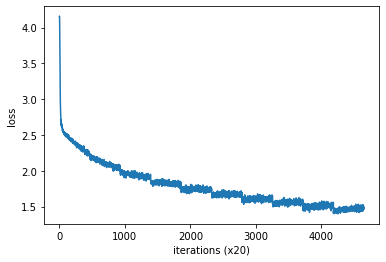

In [11]:
# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

#データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train') #訓練用
vocab_size = len(word_to_id) #語彙数
contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

#モデルの作成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

#学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

#データ保存
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

損失が徐々に小さくなっているのが分かる。損失が急に小さくなる点があるのも分かる。また、今までに比べかなり計算量が多かったが、GPUを用いて15分程度で計算ができた。またGoogle Driveを確認すると、たしかにcbow_params.pklが作成されていた。大量のデータから得た学習データを得れてうれしかった。

CBOWモデルの評価\
most_similar()メソッドで類似度を求める\
GPU上で行うとエラーが出てしまい、うまく実行できなかったためCPUで実行した。このノートブックではGPUで実行したものを記載し、CPUでの実行に関してはnlp4_2.ipynbにまとめた

感想\
大規模な計算を初めて行ったのでとても楽しく感じた。GPUを用いても計算にすごく時間がかかった。その割にはあまり精度はよくなくて少しがっかりしたが、さらに精度を上げるにはどうすればよいのかに興味が出てきた。\
はじめてgoogle colabを使ったため、本の内容とは別の部分でものすごく苦戦した。特に外部ファイルを利用する(モジュールのインポート)のにとても苦労した。またCPU, GPUの切り替えの時にエラーが出たが解決方法がよくわからなかった。そのためノートブックが分かれる形をとることになった。次回までに解決したい。

参考文献\
参考文献1:ゼロから作るDeep Learning Pythonで学ぶディープランニングの理論と実装\
参考文献2: google drive上のモジュールインポートについて調べるのに利用\
https://qiita.com/Kunikata/items/45e731753e97bda28aab